In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../main/')
from multi_py.multi import *
import numpy as np
import sys  
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.io import readsav
import copy
import pandas as pd
import os
from scipy import integrate
from scipy.signal import argrelextrema
from scipy import interpolate
import pickle

%config InlineBackend.figure_format='png'
plt.style.use('default')
plt.style.use('../main/multi_py/Bergemann2020.mplstyle')

In [2]:
major_krs = [286, 291, 293, 299, 427] # 292 and 302 removed - empty gaps; 457 removed - does not appear in the ref paper
sol_mus = [1.0, 0.9, 0.8, 0.6, 0.4, 0.2]


## Read in simulated spectrum

In [3]:
def get_lines(thisrun, krs):
    lines = []
    for kr in krs:
        lines.append(thisrun.line[kr])
    return lines

In [4]:
# runfiles = ['../runs/Si_marcs_LTE_mus/output/', '../runs/Si_stag_NLTE_5x5x230_mus/output/', '../runs/Si_stag_NLTE_10x230_mu_iter/output','../runs/SiStagNLTE_10_f3Dold/output','../runs/Si_stag_NLTE_30_old/output']
runfiles = ['../runs/Si_marcs_LTE_mus/output/', '../runs/SiStagNLTE_30_f3Dold/output/']
# runfiles = ['../runs/Si_marcs_LTE_mus/output/', '../runs/Amarsi2017_F/SiMarcsLTE/output/']

# runfiles = ['../runs/iosmet_runs/SiMarcsLTE/output/', '../runs/iosmet_runs/SiStagNLTE30_full3D/output/']


# labels = [ '1D LTE', 'stag5old1.5D', 'stag10old1.5D', 'stag5oldf3D', 'stag30old1.5D']
runobjects = [m3d(thisrun, lines=major_krs, conts=[]) for thisrun in runfiles]
linesobj = [get_lines(thisrunobj, major_krs) for thisrunobj in runobjects]

Completed reading parameters from ../runs/SiStagNLTE_30_f3Dold/output//


In [5]:
wavelengths = [line.lam0 for line in linesobj[0]]
m3d_centre_wavelengths = [5645.613, 5684.484, 5701.104, 5772.146, 7034.901]

In [6]:
def get_ang_intensity(run, kr):
    sim_fluxes = [run.line[kr].i3[:,1]]
    for i, _ in enumerate(sol_mu_ind[1:]):
        ang=i+1
        ang_idx = (ang-1)*4+1
        sim_fluxes.append(np.mean(run.line[kr].i3[:, ang_idx:ang_idx+4], axis=-1))
    return sim_fluxes

## Plot input line profiles

In [7]:
def plot_mu_intensities(line_ind):
    # define the wavelength range for this line with the m3d central wavelenght:
    line_lam = copy.deepcopy(linesobj[0][line_ind].lam)
    line_lam += m3d_centre_wavelengths[line_ind] - linesobj[0][line_ind].lam0

    sim_int_1d = get_ang_intensity(runobjects[0], kr=major_krs[line_ind])
    sim_int_1d_norm = sim_int_1d/continuum(line_lam, np.array(sim_int_1d))
    sim_int_3d = get_ang_intensity(runobjects[1], kr=major_krs[line_ind])
    sim_int_3d_norm = sim_int_3d/continuum(line_lam, np.array(sim_int_3d))

    fig, ax = plt.subplots(len(sol_mu_ind), 1, figsize=(17,25))

    for i, mu in enumerate(sol_mu_ind):
        # plot 1D LTE with cmacroturbulence onvolution Vmac = 3km
        ax[i].plot(line_lam, sim_int_1d_norm[i], label=f'1D LTE')
        ax[i].plot(*convol(line_lam, sim_int_1d_norm[i], zeta_rt=3), label=f'1D LTE conv')

        ax[i].plot(line_lam, sim_int_3d_norm[i], label=f'3D NLTE') 

        
        ax[i].plot(sol_lams[i], sol_fluxes[i], linestyle='none', marker='.', zorder=100, label=f'IAG solar spec')

        
        plt.sca(ax[i])
        plt.title(f'Line = {m3d_centre_wavelengths[line_ind]}, mu = {sol_mus[i]:.2f}')
        plt.xlim((m3d_centre_wavelengths[line_ind]-0.35), (m3d_centre_wavelengths[line_ind]+0.35))
        plt.ylim(0.35,1.05)
        plt.ylabel('Normalised Intensity')
        plt.xlabel('λ (Å)')
        plt.legend()
#     fig.savefig('../plots/kr5645_1.5D.pdf')

In [8]:
def plot_mu_intensities(line_ind):
    # define the wavelength range for this line with the m3d central wavelenght:
    line_lam = copy.deepcopy(linesobj[0][line_ind].lam)
    line_lam += m3d_centre_wavelengths[line_ind] - linesobj[0][line_ind].lam0


    # get the resolved intensities for the simulated spectra
    sim_ints_norm_list = []
    for i,run in enumerate(runobjects):
        sim_int = get_ang_intensity(runobjects[i], kr=major_krs[line_ind])
        sim_ints_norm = sim_int/continuum(line_lam, np.array(sim_int))
        sim_ints_norm_list.append(sim_ints_norm)


    # sim_int_1d = get_ang_intensity(runobjects[0], kr=major_krs[line_ind])
    # sim_int_1d_norm = sim_int_1d/continuum(line_lam, np.array(sim_int_1d))
    # sim_int_3d = get_ang_intensity(runobjects[1], kr=major_krs[line_ind])
    # sim_int_3d_norm = sim_int_3d/continuum(line_lam, np.array(sim_int_3d))

    fig, ax = plt.subplots(len(sol_mu_ind), 1, figsize=(17,25))

    for i, mu in enumerate(sol_mu_ind):
        for j, run in enumerate(sim_ints_norm_list):
            ax[i].plot(line_lam, sim_ints_norm_list[j][i], label=labels[j])
            if j==0:
            # plot 1D LTE with cmacroturbulence onvolution Vmac = 3km
             ax[i].plot(*convol(line_lam, sim_ints_norm_list[j][i], zeta_rt=3), label=f'1D LTE conv')


        
        ax[i].plot(sol_lams[i], sol_fluxes[i], linestyle='none', marker='.', zorder=100, label=f'IAG solar spec')

        
        plt.sca(ax[i])
        plt.title(f'Line = {m3d_centre_wavelengths[line_ind]}, mu = {sol_mus[i]:.2f}')
        plt.xlim((m3d_centre_wavelengths[line_ind]-0.35), (m3d_centre_wavelengths[line_ind]+0.35))
        plt.ylim(0.35,1.05)
        plt.ylabel('Normalised Intensity')
        plt.xlabel('λ (Å)')
        plt.legend()
    # fig.savefig('line1_mudep.pdf')

In [9]:
plot_mu_intensities(2)

NameError: name 'sol_mu_ind' is not defined

## Read in CoG simulated spectra and calculate EWs

In [ ]:
LTE_runs = '../runs/Si_marcs_LTE_dir/'
# LTE_runs = '../runs/iosmet_runs/SiMarcsLTEdir/'
# LTE_runs = '../runs/Amarsi2017_F/SiMarcsLTEdir/'

LTE1d_cog = CoG(runs=LTE_runs, lines=major_krs)

Completed reading parameters from ../runs/Si_marcs_LTE_dir//7.76//output//


In [ ]:
def get_cog_eqw(cogobj, kr, qmax):
    all_eqws =  [cogobj.calc_weq(kr=kr, qmax=qmax, ang=ang, norm=True) for ang in range((4*len(sol_mus[1:])+1))]
    # print(all_eqws)
    kr_eqws = [all_eqws[0]]
    # print(kr_eqws)
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        kr_eqws.append(np.mean(all_eqws[ang_start:ang_end], axis=0))
        # print(f'{ang_start}:{ang_end}')
        # print(f'range-{all_eqws[ang_start]}:{all_eqws[ang_end-1]}')
    return kr_eqws

In [ ]:
def get_line_eqw(linesobj, line, qmax):
    all_eqws =  [linesobj[line].calc_weq(qmax=qmax, ang=ang, norm=True) for ang in range((4*len(sol_mus[1:])+1))]
    line_eqws = [all_eqws[0]]
    for mu, _ in enumerate(sol_mus[1:]):
        ang_start = mu*4+1
        ang_end = ang_start+4
        line_eqws.append(np.mean(all_eqws[ang_start:ang_end]))
        # print(f'{all_corrs[ang_start]}:{all_corrs[ang_end-1]}')
    return line_eqws

In [ ]:
# eqwidths_1dlte = np.array([[test_cog.calc_weq(kr=kr, ang=ang, qmax=3.5, norm=True) for ang in range(len(mu_zs))] for kr in major_krs])
eqwidths_1dlte = np.array([get_cog_eqw(cogobj=LTE1d_cog, kr=thiskr, qmax=3.5) for thiskr in major_krs])


## 1D LTE run using Amarsi 2017 atom file changes

In [ ]:
Ama_1DLTE_runfile = '../runs/Amarsi2017_F/SiMarcsLTE/output/'
Ama_1DLTE_runobj = m3d(Ama_1DLTE_runfile, lines=major_krs, conts=[])
Ama_1DLTE_lines = get_lines(Ama_1DLTE_runobj, major_krs)

Completed reading parameters from ../runs/Amarsi2017_F/SiMarcsLTE/output//


In [ ]:
Ama_1DLTE_EWs = [get_line_eqw(linesobj=Ama_1DLTE_lines, line=thisline, qmax=3.5) for thisline in range(len((Ama_1DLTE_lines)))]

In [ ]:
Ama_1DLTE_EWs[0]

[38.38847249864396,
 38.53140349698416,
 38.48574100116778,
 37.545393351420046,
 34.76445092912215,
 28.646583895996393]

## Plot EWs vs mu angles for CoG 1D LTE, 3D NLTE and observed spectra


In [ ]:
NLTE3d_runfile = '../runs/SiStagNLTE_30_f3Dold/output/'
NLTE3d_runobj = m3d(NLTE3d_runfile, lines=major_krs, conts=[])
NLTE3d_lines = get_lines(NLTE3d_runobj, major_krs)

Completed reading parameters from ../runs/SiStagNLTE_30_f3Dold/output//


In [ ]:
NLTE3d_EWs = [get_line_eqw(linesobj=NLTE3d_lines, line=thisline, qmax=3.5) for thisline in range(len((NLTE3d_lines)))]

In [ ]:
# fig, axs = plt.subplots(2,3, figsize=(15,8),squeeze=True)

# # for i, run in enumerate(ex_1d_eqw):
# #     axs[1,1].plot(sol_mus, ex_1d_eqw[:,i], '--o', label=round(test_cog.abnds[i],2))
# count = 0
# for col, ax in zip(range(len(major_krs)), axs.flatten()):

#     # ax.plot(sol_mus, eq_iag[col],'r--x', label='IAG')
#     # ax.set_xlabel('mu')
#     # ax.set_ylabel('Eq. width, mÅ')
#     # ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#     # for i, run in enumerate(LTE1d_cog.abnds):
#     #     ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

#     # plot the 3D NLTE EWs
    
#     if col==0 or col==3 or col==4:


#         ax.plot(sol_mus, eq_iag[col],'r--x', label='IAG')
#         ax.set_xlabel('mu')
#         ax.set_ylabel('Eq. width, mÅ')
#         ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#         for i, run in enumerate(LTE1d_cog.abnds):
#             ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

#         # plot the 3D NLTE EWs
#         ax.plot(sol_mus, eq_3DNLTE[count], label='NLTE')


#         count +=1
#     if col==4:
#         handles, labels = ax.get_legend_handles_labels()
#         fig.legend(handles, labels, loc=(0.8,0.1))


# plt.tight_layout()
# # plt.savefig('../plots/EWs_mus_IOSMET_withNLTE.pdf')

## Plot EWs after observed spectra processing

In [ ]:
with open('../mdata/new_eq_iag', "rb") as f:
    new_eq_iag = pickle.load(f)

In [ ]:
# fig, axs = plt.subplots(2,3, figsize=(15,10),squeeze=True)

# # for i, run in enumerate(ex_1d_eqw):
# #     axs[1,1].plot(sol_mus, ex_1d_eqw[:,i], '--o', label=round(test_cog.abnds[i],2))

# for col, ax in zip(range(len(major_krs)), axs.flatten()):

#     ax.plot(sol_mus, new_eq_iag[col],'r--x', label='IAG')
#     ax.set_xlabel('mu')
#     ax.set_ylabel('Eq. width, mÅ')
#     ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#     for i, run in enumerate(LTE1d_cog.abnds):
#         ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=round(LTE1d_cog.abnds[i],2))
#     ax.legend()


# plt.tight_layout()
# # plt.savefig('plots/IAG_ewq.pdf')

In [ ]:
# fig, axs = plt.subplots(2,3, figsize=(15,8),squeeze=True)

# # for i, run in enumerate(ex_1d_eqw):
# #     axs[1,1].plot(sol_mus, ex_1d_eqw[:,i], '--o', label=round(test_cog.abnds[i],2))
# count = 0
# for col, ax in zip(range(len(major_krs)), axs.flatten()):

#     # ax.plot(sol_mus, eq_iag[col],'r--x', label='IAG')
#     # ax.set_xlabel('mu')
#     # ax.set_ylabel('Eq. width, mÅ')
#     # ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#     # for i, run in enumerate(LTE1d_cog.abnds):
#     #     ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

#     # plot the 3D NLTE EWs
    
#     if col==0 or col==3 or col==4:


#         ax.plot(sol_mus, new_eq_iag[col],'r--x', label='IAG')
#         ax.set_xlabel('mu')
#         ax.set_ylabel('Eq. width, mÅ')
#         ax.set_title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[col]}')
#         for i, run in enumerate(LTE1d_cog.abnds):
#             ax.plot(sol_mus, eqwidths_1dlte[col,:,i], '--o', label=f'1D LTE {round(LTE1d_cog.abnds[i],2)}')

#         # plot the 3D NLTE EWs
#         ax.plot(sol_mus, NLTE3d_EWs[count], label='NLTE')


#         count +=1
#     if col==4:
#         handles, labels = ax.get_legend_handles_labels()
#         fig.legend(handles, labels, loc=(0.8,0.1))


# plt.tight_layout()
# # plt.savefig('../plots/EWs_mus_IOSMET_withNLTE_renormed.pdf')

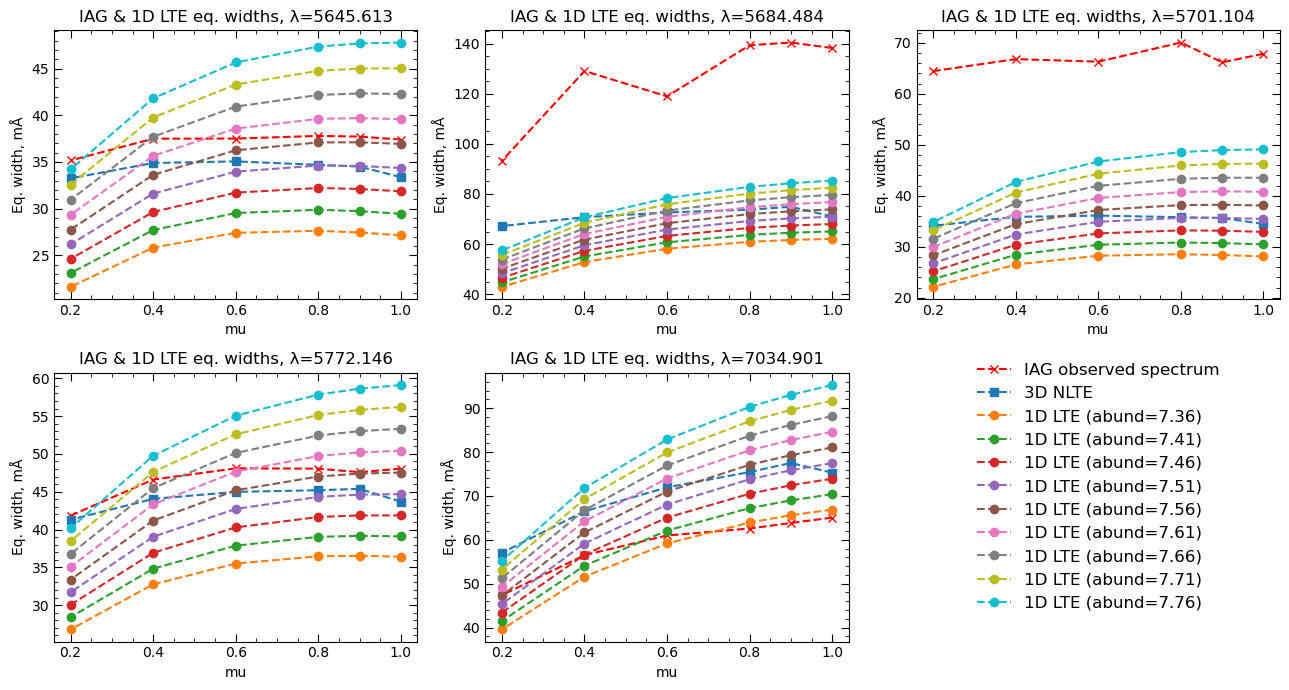

In [ ]:
# M: make EWs vs mu plot with only one 1D LTE line
fig=plt.figure(figsize=(13,7))
for i in range(1, 6):
    fig.add_subplot(2, 3, i)
    # plot observed spectra EWs
    plt.plot(sol_mus, new_eq_iag[i-1],'r--x', label='IAG observed spectrum')
    # plot the 3D NLTE EWs
    plt.plot(sol_mus, NLTE3d_EWs[i-1], '--s', label='3D NLTE')
    # plot 1D LTE EWs for abund=7.56 from CoG array of runs
    # central_abund_ind=4
    # plt.plot(sol_mus, eqwidths_1dlte[i-1,:,central_abund_ind], '--o', label=f'1D LTE (abund={round(LTE1d_cog.abnds[central_abund_ind],2)})')
    
    for j, abd in enumerate(LTE1d_cog.abnds):
        plt.plot(sol_mus, eqwidths_1dlte[i-1,:,j], '--o', label=f'1D LTE (abund={round(LTE1d_cog.abnds[j],2)})')

    
    plt.xlabel('mu')
    plt.ylabel('Eq. width, mÅ')
    plt.title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[i-1]}')
    # if i==5:
        # handles, labels = ax.get_legend_handles_labels()
        # fig.legend(handles, labels, loc=(0.8,0.1))
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75,0.10), fontsize='large')

plt.tight_layout()
# plt.savefig('../plots/EWs_renorm_allabs.pdf')

In [ ]:
LTE1d_cog.abnds

array([7.36000013, 7.40999985, 7.46000004, 7.51000023, 7.55999994,
       7.61000013, 7.65999985, 7.71000004, 7.76000023])

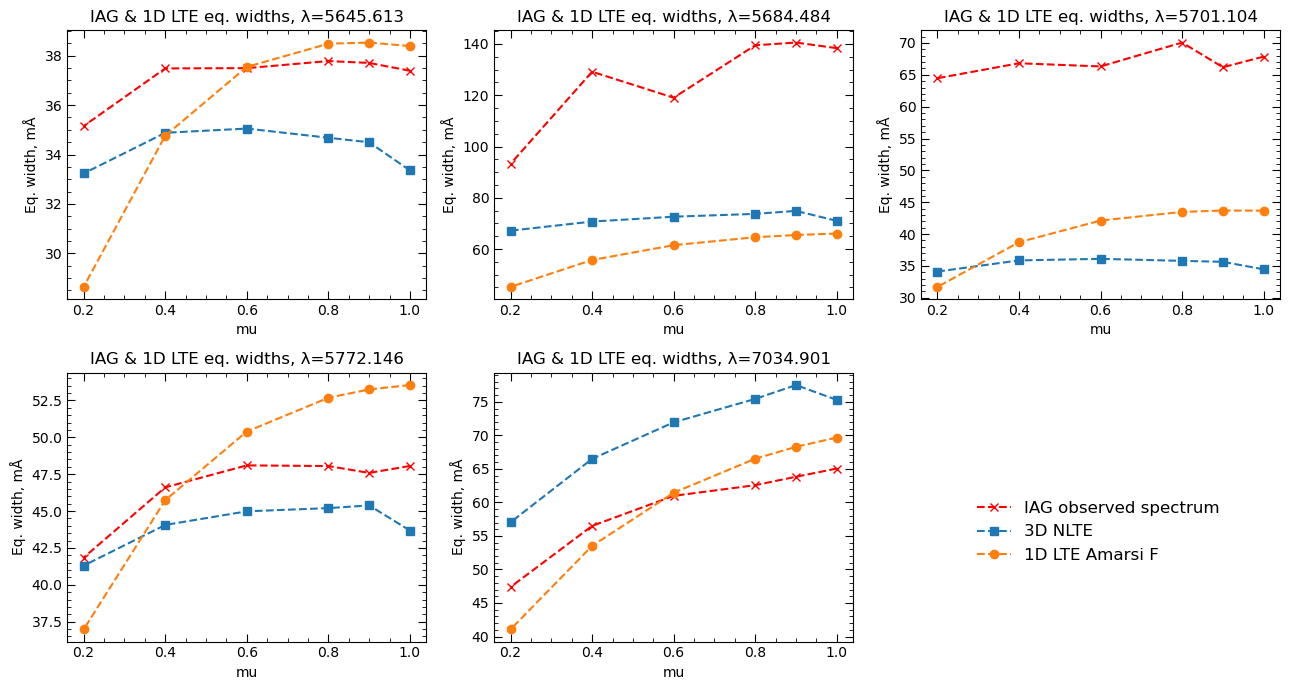

In [ ]:
# EWs vs mu plot with Amarsi atom file 1D LTE
fig=plt.figure(figsize=(13,7))
for i in range(1, 6):
    fig.add_subplot(2, 3, i)
    # plot observed spectra EWs
    plt.plot(sol_mus, new_eq_iag[i-1],'r--x', label='IAG observed spectrum')
    # plot the 3D NLTE EWs
    plt.plot(sol_mus, NLTE3d_EWs[i-1], '--s', label='3D NLTE')
    # plot 1D LTE EWs for abund=7.56 from CoG array of runs
    plt.plot(sol_mus, Ama_1DLTE_EWs[i-1], '--o', label=f'1D LTE Amarsi F')

    
    plt.xlabel('mu')
    plt.ylabel('Eq. width, mÅ')
    plt.title(f'IAG & 1D LTE eq. widths, λ={m3d_centre_wavelengths[i-1]}')
    # if i==5:
        # handles, labels = ax.get_legend_handles_labels()
        # fig.legend(handles, labels, loc=(0.8,0.1))
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75,0.17), fontsize='large')
# plt.savefig('../plots/EWs_renorm_3linesAmarsi.pdf')

plt.tight_layout()

In [ ]:
eqwidths_1dlte.shape
sol_mus

[1.0, 0.9, 0.8, 0.6, 0.4, 0.2]

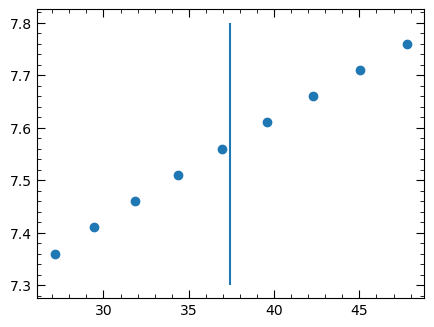

In [ ]:
plt.scatter(eqwidths_1dlte[0,0,:], LTE1d_cog.abnds)
plt.vlines(new_eq_iag[0,0], 7.3, 7.8)

## Interpolate abundances for observed spectra

In [ ]:
def interp_abund(lte1d_lines_eq, lte1d_abundances, iag_eq):
    interpd_sol_abunds = np.zeros((len(lte1d_lines_eq), len(sol_mus)), dtype=object)
    for i, line_eq in enumerate(lte1d_lines_eq):
        for j, mu in enumerate(sol_mus):
            x = lte1d_lines_eq[i,j,:]
            y = lte1d_abundances
            f = interpolate.interp1d(x,y,fill_value='extrapolate')

            interpd_sol_abunds[i,j] = f(iag_eq[i,j])
    return interpd_sol_abunds

In [ ]:
# iag_1dlte_abunds = interp_abund(np.take(eqwidths_1dlte, [0,3,4], axis=0), LTE1d_cog.abnds, np.take(new_eq_iag, [0,3,4], axis=0))
iag_1dlte_abunds = interp_abund(eqwidths_1dlte,  LTE1d_cog.abnds, new_eq_iag)

In [ ]:
iag_1dlte_abunds[0,:]

array([array(7.5687147), array(7.57175371), array(7.5738413),
       array(7.58695404), array(7.65488745), array(7.78936987)],
      dtype=object)

In [ ]:
# NLTE3Dcorrections = np.load('../mdata/3DNLTE_abund_corr_old30_newang.npy')
NLTE3Dcorrections = np.load('../mdata/3DNLTE_abund_corr_no_iosmet_5wls.npy')


In [ ]:
# NLTE3Dcorrections.reshape(3,6)

In [ ]:
# iag_3DNLTE_corrected_abund = np.add(iag_1dlte_abunds, NLTE3Dcorrections.reshape(3,6))
iag_3DNLTE_corrected_abund = np.add(iag_1dlte_abunds, NLTE3Dcorrections)

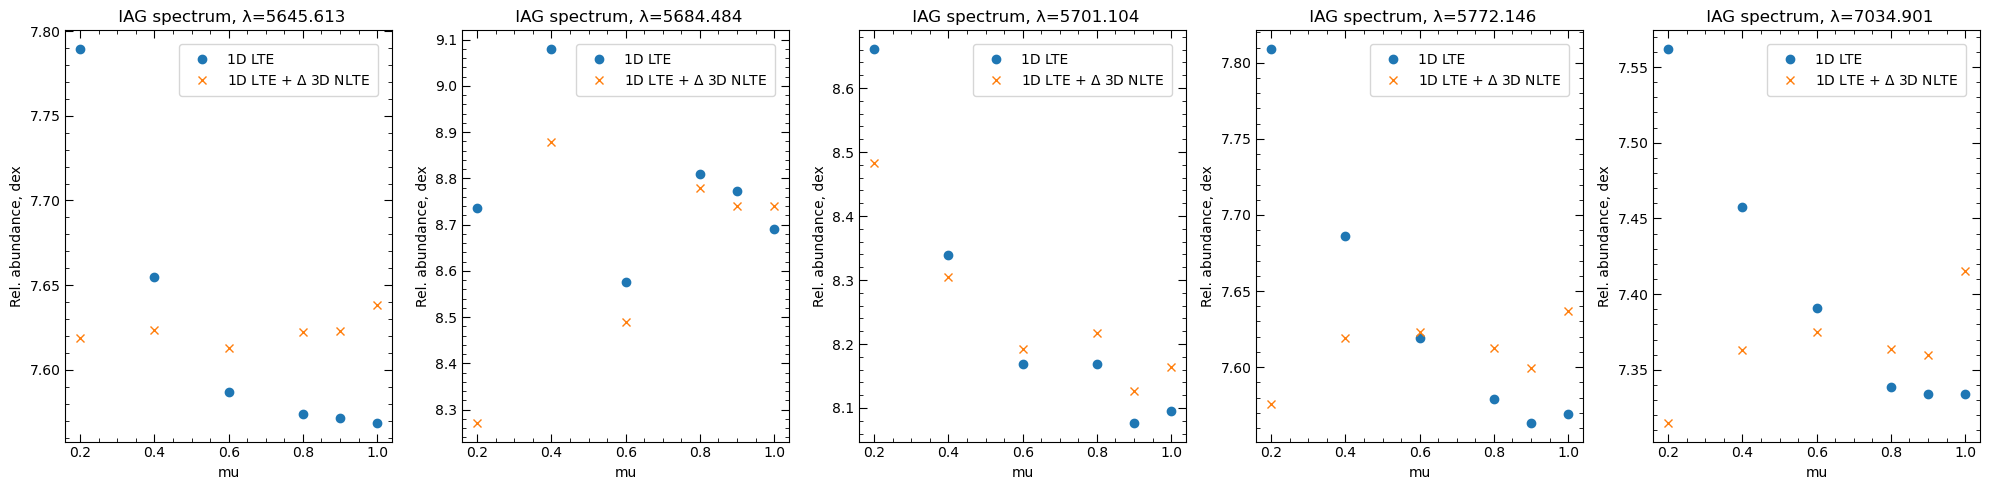

In [ ]:
fig, ax = plt.subplots(1,len(iag_1dlte_abunds), figsize=(20,5))

for i, line in enumerate(iag_1dlte_abunds):
    ax[i].plot(sol_mus, iag_1dlte_abunds[i], 'o', label='1D LTE')
    ax[i].plot(sol_mus, iag_3DNLTE_corrected_abund[i], 'x', label='1D LTE + $\Delta$ 3D NLTE')

    ax[i].set_xlabel('mu')
    ax[i].set_ylabel('Rel. abundance, dex')
    # ax[i].set_title(f' IAG spectrum, λ={np.take(m3d_centre_wavelengths,[0,3,4])[i]}')
    ax[i].set_title(f' IAG spectrum, λ={m3d_centre_wavelengths[i]}')

    # ax[i].set_ylim(7.46, 7.65)
    ax[i].legend(frameon=1)
plt.tight_layout()
# fig.savefig('../plots/abnd_calc.pdf')